#Secondo homework
**Bartolomeo Caruso** || **Matricola: 1000008726**

---
##Step 1: Caricamento del dataset
Caricamento del dataset e implemenmtazione di funzioni utili per la creazione di train set e test set


In [ ]:
import torch
import random as rng
from matplotlib import pyplot as plt
from torchvision import datasets
import torchvision.transforms.functional as TF

# Load MNIST dataset
train_dataset = datasets.MNIST(root="..", download=True, train=True)
test_dataset = datasets.MNIST(root="..", download=True, train=False)

def generate_set(dataset, n_elements, n_features):
  X = torch.Tensor(n_elements, n_features)
  y = torch.Tensor(n_elements).long()
  for i in range(n_elements):
    tensor_image_element = TF.to_tensor(dataset[i][0]).view(-1)
    #Add data to X_train and y_train
    X[i,:] = tensor_image_element
    y[i] = dataset[i][1]
  return X, y

def generate_set_index(dataset, n_elements, n_features, shuffled_index):
  X = torch.Tensor(n_elements, n_features)
  y = torch.Tensor(n_elements).long()
  for i, index in enumerate(shuffled_index):
    tensor_image_element = TF.to_tensor(dataset[index][0]).view(-1)
    #Add data to X_train and y_train
    X[i,:] = tensor_image_element
    y[i] = dataset[index][1]
  return X, y




Extracting ../MNIST/raw/train-images-idx3-ubyte.gz to ../MNIST/raw




Extracting ../MNIST/raw/train-labels-idx1-ubyte.gz to ../MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../MNIST/raw/t10k-images-idx3-ubyte.gz to ../MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../MNIST/raw/t10k-labels-idx1-ubyte.gz to ../MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


---
##Step 2: Introduzione della funzione di standardizzazione
In tale step è necessario implementare una strategia che impedisca di eseguire una divisione per zero al momento della standardizzazione.

Per evitare tale problema si è pensato di rimuovere tutte le features che portano ad una deviazione standard nulla: in questo modo la standardizzazione può avvenire senza problemi, e l'immagine che si ottiene in seguito non sarà compromessa.


In [ ]:
#Standardization
def standardize(XTrain = "vuoto", XValidation = "vuoto", XTest = "vuoto"):
  #1: Obtain X_train_std
  X_train_std = XTrain.std(0)
  #2: Obtain new XTrain, XValidation and XTest removing zero values standard deviation elements
  XTrain = XTrain[:, X_train_std != 0]
  if (XValidation != "vuoto"):
    XValidation = XValidation[:, X_train_std != 0]
  if (XTest != "vuoto"):
    XTest = XTest[:, X_train_std != 0]
  #3: Proceed as usual, obtain mean value and standard deviation
  X_train_mean = XTrain.mean(0) 
  X_train_std = XTrain.std(0) 
  #4: Standardization calculus
  XTrain = (XTrain - X_train_mean)/X_train_std
  if (XTest != "vuoto"):
    XTest = (XTest - X_train_mean)/X_train_std
  if (XValidation != "vuoto"):
    XValidation = (XValidation - X_train_mean)/X_train_std
  return XTrain, XValidation, XTest



---
#Step 3: Introduzione del modello MLP e delle apposite funzioni di training
Di verrano introdotte 2 funzioni di training, in modo da permettere un training con validation e senza validation set.

In [ ]:
#MLP model
import torch.optim as optim
import torch.nn as nn # layers with parameters
import torch.nn.functional as F # layers without parameters (e.g. activation functions)
class MLP(nn.Module):
    #Constructor
    def __init__(self, input_size, hidden_size, output_size):
        #Call parent constructor
        super().__init__()
        #Define layers
        self.hidden_layer = nn.Linear(input_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size, output_size)
        
    #Forward (prediction)
    def forward(self, x):
        #Go through network
        x = torch.tanh(self.hidden_layer(x))
        x = self.output_layer(x)
        #Return output
        return x

def no_validation_train(model, X_train, y_train, X_test, y_test, epochs, lr=0.01):
    # Optimizer
    optimizer = optim.SGD(model.parameters(), lr=lr)
    # Get sizes
    num_train = X_train.size(0)
    num_test = X_test.size(0)
    # Initialize history
    history_train_loss = []
    history_train_accuracy = []
    history_test_loss = []
    history_test_accuracy = []
    for epoch in range(epochs):
        # Initialize epoch variables
        sum_train_loss = 0
        sum_test_loss = 0
        sum_validation_loss = 0
        sum_train_accuracy = 0
        sum_test_accuracy = 0
        sum_validation_accuracy = 0
        # Enable gradient computation
        torch.set_grad_enabled(True)
        # Process training data
        for i in range(num_train):
            # Reset gradients
            optimizer.zero_grad()
            # Get sample i
            features = X_train[i,:]
            label = y_train[i]
            # Add batch dimension (event if it's 1)
            features.unsqueeze_(0)
            label.unsqueeze_(0)
            # Compute output
            pred = model(features)
            loss = F.cross_entropy(pred, label)
            # Update train loss
            sum_train_loss += loss.item()
            # Compute gradients
            loss.backward()
            # Optimize
            optimizer.step()
            # Update train accuracy
            _,pred_label = pred.max(1)
            pred_label = pred_label.item()
            if pred_label == label.item():
                sum_train_accuracy += 1
        # Disable gradient computation
        torch.set_grad_enabled(False)
        for i in range(num_test):
            # Get sample i
            features = X_test[i,:]
            label = y_test[i]
            # Add batch dimension (event if it's 1)
            features.unsqueeze_(0)
            label.unsqueeze_(0)
            # Compute output
            pred = model(features)
            loss = F.cross_entropy(pred, label)
            # Update test loss
            sum_test_loss += loss.item()
            # Update test accuracy
            _,pred_label = pred.max(1)
            pred_label = pred_label.item()
            if pred_label == label.item():
                sum_test_accuracy += 1
        # Update history
        epoch_train_loss = sum_train_loss/num_train
        epoch_train_accuracy = sum_train_accuracy/num_train
        epoch_test_loss = sum_test_loss/num_test
        epoch_test_accuracy = sum_test_accuracy/num_test
        history_train_loss.append(epoch_train_loss)
        history_train_accuracy.append(epoch_train_accuracy)
        history_test_loss.append(epoch_test_loss)
        history_test_accuracy.append(epoch_test_accuracy)
        # Print info
        print(f"Epoch {epoch}:",
              f"TrL={epoch_train_loss:.4f},",
              f"TrA={epoch_train_accuracy:.4f},",
              f"TeL={epoch_test_loss:.4f},",
              f"TeA={epoch_test_accuracy:.4f}")
    # Plot loss
    plt.title("Loss")
    plt.plot(history_train_loss, label='train')
    plt.plot(history_test_loss, label='test')
    plt.legend()
    plt.show()
    # Plot accuracy
    plt.title("Accuracy")
    plt.plot(history_train_accuracy, label='train')
    plt.plot(history_test_accuracy, label='test')
    plt.legend()
    plt.show()

def validation_train(model, X_train, y_train, X_test, y_test, X_validation, y_validation, epochs, lr=0.01):
    # Optimizer
    optimizer = optim.SGD(model.parameters(), lr=lr)
    # Get sizes
    num_train = X_train.size(0)
    num_validation = X_validation.size(0)
    num_test = X_test.size(0)
    # Initialize history
    history_train_loss = []
    history_train_accuracy = []
    history_validation_loss = []
    history_validation_accuracy = []
    history_test_loss = []
    history_test_accuracy = []
    for epoch in range(epochs):
        # Initialize epoch variables
        sum_train_loss = 0
        sum_test_loss = 0
        sum_validation_loss = 0
        sum_train_accuracy = 0
        sum_test_accuracy = 0
        sum_validation_accuracy = 0
        # Enable gradient computation
        torch.set_grad_enabled(True)
        # Process training data
        for i in range(num_train):
            # Reset gradients
            optimizer.zero_grad()
            # Get sample i
            features = X_train[i,:]
            label = y_train[i]
            # Add batch dimension (event if it's 1)
            features.unsqueeze_(0)
            label.unsqueeze_(0)
            # Compute output
            pred = model(features)
            loss = F.cross_entropy(pred, label)
            # Update train loss
            sum_train_loss += loss.item()
            # Compute gradients
            loss.backward()
            # Optimize
            optimizer.step()
            # Update train accuracy
            _,pred_label = pred.max(1)
            pred_label = pred_label.item()
            if pred_label == label.item():
                sum_train_accuracy += 1
        # Process validation data
        # Disable gradient computation
        torch.set_grad_enabled(False) 
        for i in range(num_validation):
            # Get sample i
            features = X_validation[i,:]
            label = y_validation[i]
            # Add batch dimension (event if it's 1)
            features.unsqueeze_(0)
            label.unsqueeze_(0)
            # Compute output
            pred = model(features)
            loss = F.cross_entropy(pred, label)
            # Update test loss
            sum_validation_loss += loss.item()
            # Update test accuracy
            _,pred_label = pred.max(1)
            pred_label = pred_label.item()
            if pred_label == label.item():
                sum_validation_accuracy += 1
        # Process test data
        # Disable gradient computation
        torch.set_grad_enabled(False) 
        # Process test data
        for i in range(num_test):
            # Get sample i
            features = X_test[i,:]
            label = y_test[i]
            # Add batch dimension (event if it's 1)
            features.unsqueeze_(0)
            label.unsqueeze_(0)
            # Compute output
            pred = model(features)
            loss = F.cross_entropy(pred, label)
            # Update test loss
            sum_test_loss += loss.item()
            # Update test accuracy
            _,pred_label = pred.max(1)
            pred_label = pred_label.item()
            if pred_label == label.item():
                sum_test_accuracy += 1
        # Update history
        epoch_train_loss = sum_train_loss/num_train
        epoch_train_accuracy = sum_train_accuracy/num_train
        epoch_test_loss = sum_test_loss/num_test
        epoch_test_accuracy = sum_test_accuracy/num_test
        epoch_validation_loss = sum_validation_loss/num_validation
        epoch_validation_accuracy = sum_validation_accuracy/num_validation
        history_train_loss.append(epoch_train_loss)
        history_train_accuracy.append(epoch_train_accuracy)
        history_validation_loss.append(epoch_validation_loss)
        history_validation_accuracy.append(epoch_validation_accuracy)
        history_test_loss.append(epoch_test_loss)
        history_test_accuracy.append(epoch_test_accuracy)
        # Print info
        print(f"Epoch {epoch}:",
              f"TrL={epoch_train_loss:.4f},",
              f"TrA={epoch_train_accuracy:.4f},",
              f"VaL={epoch_validation_loss:.4f},",
              f"VaA={epoch_validation_accuracy:.4f},",
              f"TeL={epoch_test_loss:.4f},",
              f"TeA={epoch_test_accuracy:.4f}")
    # Plot loss
    plt.title("Loss")
    plt.plot(history_train_loss, label='train')
    plt.plot(history_validation_loss, label='validation')
    plt.plot(history_test_loss, label='test')
    plt.legend()
    plt.show()
    # Plot accuracy
    plt.title("Accuracy")
    plt.plot(history_train_accuracy, label='train')
    plt.plot(history_validation_accuracy, label='validation')
    plt.plot(history_test_accuracy, label='test')
    plt.legend()
    plt.show()

##Step 4: Shuffle dei dati e primo training
Al seguito dello shuffle si eseguirà un training senza validation set.

In tale step è necessario implementare una strategia che non saturi la RAM messa a disposizione da google colab, a causa dell'eccessivo numero di sample da utilizzare durante il training: sulla base del consiglio posto all'inizio di tale homework, si pensa di conservare gli **indici dei dati contenuti in X_train e X_test**.

Attenzione, in quanto si lavora adoperando degli indici non è più necesaria la funzione randperm: questa difatti ritorna una permutazione randomica di un dato tensore.

Number of features is: 784
Number of possible outputs 10
Epoch 0: TrL=0.4013, TrA=0.9001, TeL=0.2534, TeA=0.9281
Epoch 1: TrL=0.2258, TrA=0.9357, TeL=0.2182, TeA=0.9367
Epoch 2: TrL=0.1911, TrA=0.9452, TeL=0.2023, TeA=0.9417
Epoch 3: TrL=0.1704, TrA=0.9510, TeL=0.1928, TeA=0.9429
Epoch 4: TrL=0.1556, TrA=0.9553, TeL=0.1882, TeA=0.9435
Epoch 5: TrL=0.1439, TrA=0.9591, TeL=0.1851, TeA=0.9445
Epoch 6: TrL=0.1348, TrA=0.9623, TeL=0.1837, TeA=0.9449
Epoch 7: TrL=0.1267, TrA=0.9650, TeL=0.1809, TeA=0.9448
Epoch 8: TrL=0.1199, TrA=0.9671, TeL=0.1793, TeA=0.9460
Epoch 9: TrL=0.1140, TrA=0.9687, TeL=0.1773, TeA=0.9470
Epoch 10: TrL=0.1088, TrA=0.9705, TeL=0.1773, TeA=0.9468
Epoch 11: TrL=0.1043, TrA=0.9717, TeL=0.1784, TeA=0.9475
Epoch 12: TrL=0.1001, TrA=0.9727, TeL=0.1789, TeA=0.9480
Epoch 13: TrL=0.0968, TrA=0.9737, TeL=0.1789, TeA=0.9482
Epoch 14: TrL=0.0935, TrA=0.9746, TeL=0.1800, TeA=0.9472
Epoch 15: TrL=0.0900, TrA=0.9758, TeL=0.1806, TeA=0.9466
Epoch 16: TrL=0.0866, TrA=0.9769, TeL=0.1

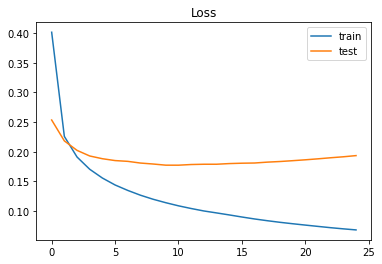

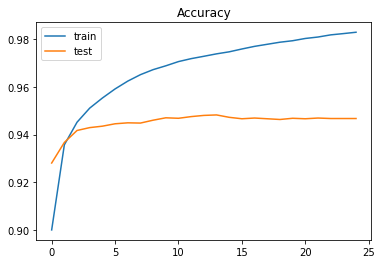

In [ ]:
#Index generation using range function
train_index = list(range(60000))
test_index = list(range(10000))
rng.shuffle(train_index)
#No need to shuffle test index...
n_features = TF.to_tensor(train_dataset[0][0]).view(-1).size(0)
print("Number of features is: {0}".format(n_features));

X_train, y_train = generate_set_index(train_dataset, 60000, n_features, train_index)
X_test, y_test = generate_set_index(test_dataset, 10000, n_features, test_index)

X_train, _, X_test = standardize(XTrain = X_train, XTest = X_test)

#Prepare model
input_size = X_train.size(1)
hidden_size = 25
output_size = y_train.max().item() + 1
print("Number of possible outputs {0}".format(output_size))
model = MLP(input_size, hidden_size, output_size)

#Train model
no_validation_train(model, X_train, y_train, X_test, y_test, epochs=25, lr=0.001)

#Step 5: Eseguire un training mediante splitting in validation set e training set

Per eseguire tale splitting verrà introdotta una funzione che permette di ottenere uno splitting sulla base di un rateo di splitting

In [ ]:
#Define splitting function
def validation_set_create(NTrain, ValidationRatio, TrainIndex):
  NValidation = int(NTrain * ValidationRatio) #Cast to avoid double value
  NTrain = NTrain - NValidation #Still used to avoid approximation problems
  validation_index = TrainIndex[NTrain:]
  new_train_index = TrainIndex[:NTrain]
  return validation_index, new_train_index, NTrain

Number of possible outputs 10
Epoch 0: TrL=0.4204, TrA=0.8927, VaL=0.2812, VaA=0.9215, TeL=0.2637, TeA=0.9263
Epoch 1: TrL=0.2319, TrA=0.9346, VaL=0.2444, VaA=0.9312, TeL=0.2275, TeA=0.9353
Epoch 2: TrL=0.1960, TrA=0.9442, VaL=0.2296, VaA=0.9350, TeL=0.2110, TeA=0.9391
Epoch 3: TrL=0.1745, TrA=0.9499, VaL=0.2212, VaA=0.9380, TeL=0.2006, TeA=0.9409
Epoch 4: TrL=0.1588, TrA=0.9548, VaL=0.2159, VaA=0.9388, TeL=0.1945, TeA=0.9411
Epoch 5: TrL=0.1463, TrA=0.9582, VaL=0.2119, VaA=0.9395, TeL=0.1905, TeA=0.9441
Epoch 6: TrL=0.1364, TrA=0.9612, VaL=0.2102, VaA=0.9407, TeL=0.1882, TeA=0.9457
Epoch 7: TrL=0.1281, TrA=0.9639, VaL=0.2093, VaA=0.9410, TeL=0.1865, TeA=0.9463
Epoch 8: TrL=0.1210, TrA=0.9658, VaL=0.2093, VaA=0.9412, TeL=0.1858, TeA=0.9462
Epoch 9: TrL=0.1147, TrA=0.9681, VaL=0.2094, VaA=0.9408, TeL=0.1854, TeA=0.9463
Epoch 10: TrL=0.1091, TrA=0.9693, VaL=0.2102, VaA=0.9405, TeL=0.1854, TeA=0.9468
Epoch 11: TrL=0.1041, TrA=0.9711, VaL=0.2111, VaA=0.9402, TeL=0.1853, TeA=0.9476
Epoch 12

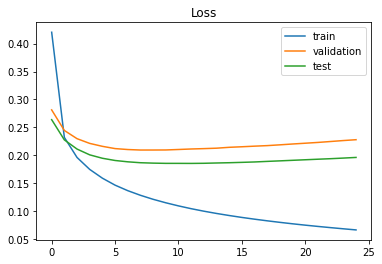

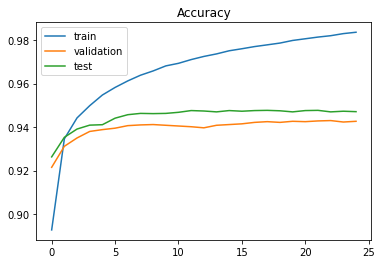

In [ ]:
#Index generation using range function
train_index = list(range(60000))
test_index = list(range(10000))
rng.shuffle(train_index)
val_index, train_index, new_n_train = validation_set_create(60000, 0.1, train_index)

X_train, y_train = generate_set_index(train_dataset, new_n_train, n_features, train_index)
X_validation, y_validation = generate_set_index(train_dataset, 60000 - new_n_train, n_features, val_index)
X_test, y_test = generate_set_index(test_dataset, 10000, n_features, test_index)

X_train, X_validation, X_test = standardize(XTrain = X_train, XValidation = X_validation, XTest=X_test)

#Prepare model
input_size = X_train.size(1)
hidden_size = 25
output_size = y_train.max().item() + 1
print("Number of possible outputs {0}".format(output_size))
model = MLP(input_size, hidden_size, output_size)

#Train model
validation_train(model, X_train, y_train, X_test, y_test, X_validation, y_validation, epochs=25, lr=0.001)

##Step 6: Organizzare il codice in mini batch
Si ricordi quanto segue:
- Batch: permette una logica di utilizzo di tutti i dati a disposizione per calcolare il gradiente durante una singola iterazione.
- Mini-batch: permette una logica ove si prende solo un subset dei dati a disposizione durante una singola iterazione. 

Data una dimensione B per ciascuna mini-batch, si ottiene un numero di mini-batch calcolato come N/B, ove il valore N è il numero di elementi/righe del dataset.

Una singola mini batch può essere quindi considerata come una matrice, ove la seconda dimensione sono le "osservazioni" del dataset di partenza.

Ricorda che durante la creazione di una mini batch di forma B*F, ove F è l'ammontare delle features, si ha quanto segue:
- Le features necessitano di una **concatenazione verticale**: una volta estratte dal dataset, queste risulteranno essere un vettore monodimensionale, motivo per cui è necessario trasformarle in un vettore bidimensionale per una corretta concatenazione.
Per eseguire ciò si ricorre alla funzione di unsqueeze.
- Le labels sono vettori monodimensionali: basta semplicemente convertirli in tensori.

In [ ]:
#Function used to obtain the correct amount of batch based on the single batch size
def batch_number_calculator(size_of_single_batch, train_amount, test_amount, validation_amount = 0):
  #Calculate how many batch for each set, using floor
  nb_train = train_amount//size_of_single_batch
  nb_test = test_amount//size_of_single_batch
  nb_validation = validation_amount//size_of_single_batch
  return nb_train, nb_test, nb_validation

#Function used to obtain i-th batch from a certain set: "i" will be called "actualBatch"
def batch_calculator(index, X, Y, size_of_single_batch, actualBatch):
  #Obtain from trainIndex a batchIndex
  startIndex = actualBatch*size_of_single_batch
  endIndex = startIndex + size_of_single_batch
  batchIndex = index[startIndex : endIndex]
  #Obtain from dataset the items to put in a single batch
  features = [X[elem_index,:].unsqueeze(0) for elem_index in batchIndex]
  features = torch.cat(features, 0)
  labels = [Y[elem_index] for elem_index in batchIndex]
  labels = torch.tensor(labels)
  # Return
  return features, labels

#Training function that uses batch
def batch_train(model, X_train, y_train, X_test, y_test, epochs, trainIndex, testIndex, nbatchtrain, nbatchtest, size_of_single_batch, lr=0.01):
    # Optimizer
    optimizer = optim.SGD(model.parameters(), lr=lr)
    # Initialize history
    history_train_loss = []
    history_train_accuracy = []
    history_test_loss = []
    history_test_accuracy = []
    for epoch in range(epochs):
        # Initialize epoch variables
        sum_train_loss = 0
        sum_test_loss = 0
        sum_train_accuracy = 0
        sum_test_accuracy = 0
        # Enable gradient computation
        torch.set_grad_enabled(True)
        # Process training data
        #This time the training must be done batch by batch and not data by data
        for j in range(nbatchtrain):
          # Reset gradients
          optimizer.zero_grad()
          # Get batch
          features, labels = batch_calculator(trainIndex, X_train, y_train, size_of_single_batch, j)
          # Compute output
          pred = model(features)
          loss = F.cross_entropy(pred, labels)
          # Update train loss
          sum_train_loss += loss.item()
          # Compute gradients
          loss.backward()
          # Optimize
          optimizer.step()
          # Update train accuracy: this time the update must consider the batch, so all correct predictions inside the batch must be considered
          _,pred_labels = pred.max(1)
          batch_train_accuracy = (pred_labels == labels).sum().item()/size_of_single_batch
          # Update accuracy
          sum_train_accuracy += batch_train_accuracy
        # Disable gradient computation
        torch.set_grad_enabled(False)
        #This time the test must be done batch by batch and not data by data
        for j in range(nbatchtest):
          # Get batch
          features, labels = batch_calculator(testIndex, X_test, y_test, size_of_single_batch, j)
          # Compute output
          pred = model(features)
          loss = F.cross_entropy(pred, labels)
          # Update test loss
          sum_test_loss += loss.item()
          # Update batch test accuracy: this time the update must consider the batch, so all correct predictions inside the batch must be considered
          _,pred_labels = pred.max(1)
          batch_test_accuracy = (pred_labels == labels).sum().item()/size_of_single_batch
          # Update accuracy
          sum_test_accuracy += batch_test_accuracy
        # Update history
        epoch_train_loss = sum_train_loss/nbatchtrain
        epoch_train_accuracy = sum_train_accuracy/nbatchtrain
        epoch_test_loss = sum_test_loss/nbatchtest
        epoch_test_accuracy = sum_test_accuracy/nbatchtest
        history_train_loss.append(epoch_train_loss)
        history_train_accuracy.append(epoch_train_accuracy)
        history_test_loss.append(epoch_test_loss)
        history_test_accuracy.append(epoch_test_accuracy)
        # Print info
        print(f"Epoch {epoch}:",
              f"TrL={epoch_train_loss:.4f},",
              f"TrA={epoch_train_accuracy:.4f},",
              f"TeL={epoch_test_loss:.4f},",
              f"TeA={epoch_test_accuracy:.4f}")
    # Plot loss
    plt.title("Loss")
    plt.plot(history_train_loss, label='train')
    plt.plot(history_test_loss, label='test')
    plt.legend()
    plt.show()
    # Plot accuracy
    plt.title("Accuracy")
    plt.plot(history_train_accuracy, label='train')
    plt.plot(history_test_accuracy, label='test')
    plt.legend()
    plt.show()

Number of possible outputs 10
Epoch 0: TrL=1.3303, TrA=0.7267, TeL=0.8785, TeA=0.8401
Epoch 1: TrL=0.7236, TrA=0.8561, TeL=0.5950, TeA=0.8783
Epoch 2: TrL=0.5388, TrA=0.8821, TeL=0.4798, TeA=0.8911
Epoch 3: TrL=0.4527, TrA=0.8940, TeL=0.4193, TeA=0.8985
Epoch 4: TrL=0.4031, TrA=0.9009, TeL=0.3819, TeA=0.9036
Epoch 5: TrL=0.3702, TrA=0.9057, TeL=0.3562, TeA=0.9077
Epoch 6: TrL=0.3465, TrA=0.9099, TeL=0.3373, TeA=0.9106
Epoch 7: TrL=0.3282, TrA=0.9137, TeL=0.3227, TeA=0.9139
Epoch 8: TrL=0.3136, TrA=0.9164, TeL=0.3109, TeA=0.9162
Epoch 9: TrL=0.3015, TrA=0.9190, TeL=0.3013, TeA=0.9178
Epoch 10: TrL=0.2912, TrA=0.9212, TeL=0.2931, TeA=0.9201
Epoch 11: TrL=0.2823, TrA=0.9232, TeL=0.2861, TeA=0.9221
Epoch 12: TrL=0.2745, TrA=0.9253, TeL=0.2800, TeA=0.9234
Epoch 13: TrL=0.2676, TrA=0.9271, TeL=0.2747, TeA=0.9237
Epoch 14: TrL=0.2613, TrA=0.9286, TeL=0.2699, TeA=0.9246
Epoch 15: TrL=0.2556, TrA=0.9302, TeL=0.2656, TeA=0.9258
Epoch 16: TrL=0.2504, TrA=0.9315, TeL=0.2617, TeA=0.9266
Epoch 17: T

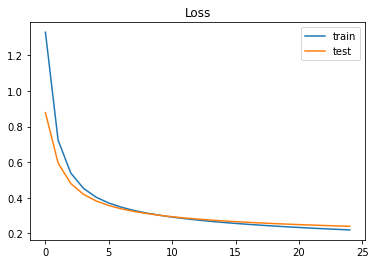

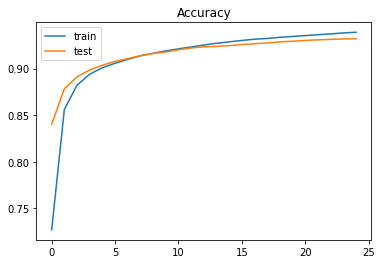

In [ ]:
#Prepare again the dataset
train_index = list(range(60000))
test_index = list(range(10000))
rng.shuffle(train_index)

X_train, y_train = generate_set_index(train_dataset, 60000, n_features, train_index)
X_test, y_test = generate_set_index(test_dataset, 10000, n_features, test_index)

#Standardize
X_train, _, X_test = standardize(XTrain = X_train, XTest = X_test)
#Obtain batch number
NBtrain, NBtest, _ = batch_number_calculator(20, 60000, 10000)

#Prepare model
input_size = X_train.size(1)
hidden_size = 25
output_size = y_train.max().item() + 1
print("Number of possible outputs {0}".format(output_size))
model_batch = MLP(input_size, hidden_size, output_size)

#Train model
batch_train(model_batch, X_train, y_train, X_test, y_test, 25, train_index, test_index, NBtrain, NBtest, 20, lr=0.001)


#Consigli del professore

- Richiama la funzione di shuffle ad ogni epoca della funzione di training, questo migliora le capacità di apprendimento e rimuove qualsiasi tipo di dipendenza dalla posizione degli elementi

- Quando si deve eseguire un report dell'accuratezza, non si può rispondere con la migliore accuratezza del test set tra le epoche calcolate, ma si risponde con la migliore accuratezza del validation set tra le epoche calcolate.

- Se non si adopera un validation set, un report dell'accuratezza riporterà la migliore accuratezza del training set. 

- In caso di overfitting alla migliore accuratezza del training set corrisponderà un cattivo valore di acuratezza sul test set.

- Se si standardizza, si assume che i valori sono distribuiti secondo una gaussiana. In MNIST le immagini contengono valori quasi perfettamente binari (i valori dei pixel variano da 0 a -1), e per tale motivo la distribuzione dei valori non è gaussiana, non solo le immagini contengoo un numero sbilanciato di pixel neri rispetto a quelli bianchi.
In questi casi si ricorre ad un modo differente di pre-processing:
  - Porre pixel neri tutti 0 e bianchi tutti 1
  - Porre pixel neri tutti -1 e bianchi tutti 1: questo modo è molto più consistente da un punto di vista matematico.

Per eseguire questo tipo di preprocessing si può riccorrere ad una maschera.

In [ ]:
#Esempio
t = torch.rand(3,3)
t[t >= 0.5] = 1.0
t[t < 0.5] = 0.0
print(t)

tensor([[1., 1., 0.],
        [1., 0., 0.],
        [0., 1., 0.]])
